In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

In [4]:
from datasets import load_dataset

ds = load_dataset("google-research-datasets/go_emotions", "simplified")

### *Data Preprocessing*

* Data analysis and preparation


    Samples with multiple labels were removed to simplify the dataset, leaving only single-label entries. The label column was flattened, and unused columns were dropped to reduce unnecessary overhead. Text data was standardized by converting all text to lowercase, removing non-alphanumeric characters, and eliminating stop words (e.g., "is," "the") that do not contribute significantly to the content.

    For Random Forest (RF), the TfidfVectorizer was employed to transform the text into numerical features. For the Naive Bayes model, CountVectorizer was used to create a sparse matrix of term frequencies.

    Class distribution analysis revealed significant class imbalances, with "neutral" being the dominant class, while "grief," "pride," "nervousness," and "relief" were underrepresented. This imbalance impacted the performance of both the RF and Naive Bayes models.



In [12]:
# from https://github.com/google-research/google-research/blob/master/goemotions/data/emotions.txt
class_labels = [
    "admiration", "amusement", "anger", "annoyance", "approval", "caring", 
    "confusion", "curiosity", "desire", "disappointment", "disapproval", "disgust", 
    "embarrassment", "excitement", "fear", "gratitude", "grief", "joy", "love", 
    "nervousness", "optimism", "pride", "realization", "relief", "remorse", 
    "sadness", "surprise", "neutral"
]

stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
    'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
    'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
    'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 
    'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
    'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
    'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 
    'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 
    'don', 'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', 'couldn', 'didn', 'doesn',
    'hadn', 'hasn', 'haven', 'isn', 'ma', 'mightn', 'mustn', 'needn', 'shan', 'shouldn', 'wasn', 'weren', 
    'won', 'wouldn'
]

def preprocess_text(text):
    text = text.lower()    
    text = ''.join(char for char in text if char.isalnum() or char.isspace())    
    text = ' '.join([word for word in text.split() if word not in stop_words]) # remove stopwords    
    return text

def confusion_matrix_plot(y_test, y_pred, class_labels, model_name):
    cm = confusion_matrix(y_test, y_pred, labels=range(len(set(y_test))))
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xticks(rotation=30, ha='right') 
    plt.show()

def class_distribution_plot(y_train, class_labels, title, size=(10, 6)):
    unique_labels, counts = np.unique(y_train, return_counts=True)
    class_distribution_table = pd.DataFrame({
        'Class': unique_labels,
        'Count': counts
    })
    plt.figure(figsize=size)
    bars = plt.bar(class_distribution_table['Class'], class_distribution_table['Count'], color='cornflowerblue')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title(f'Class Distribution: {title}')
    plt.xticks(ticks=class_distribution_table['Class'], labels=class_labels, rotation=30, ha='right')
    i = 0
    class_count = {}
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=9)
        class_count[i] = height
        i += 1
    plt.tight_layout()
    plt.show()
    return class_count

def plot_accuracies(train_acc, test_acc, title):
    accuracies = [train_acc, test_acc]
    labels = ['Training Accuracy', 'Testing Accuracy']
    fig, ax = plt.subplots(figsize=(6, 5))
    bars = ax.bar(labels, accuracies, color='cornflowerblue', alpha=0.8)    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%', 
                ha='center', va='bottom', fontsize=10, color='black')    
    ax.set_ylim(0, 100)
    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title(f"Training Accuracy and Test Accuracy: {title}", fontsize=14)
    plt.tight_layout()
    plt.show()


def smote(X, y, target_class, num_samples, k_neighbors=5):
    # Separate minority class samples
    minority_indices = np.where(y == target_class)[0]
    X_minority = X[minority_indices]

    # Find k nearest neighbors
    nn = NearestNeighbors(n_neighbors=k_neighbors + 1)  # +1 to include the point itself
    nn.fit(X_minority)
    distances, indices = nn.kneighbors(X_minority)
    indices = indices[:, 1:]  # Exclude the point itself

    # Generate synthetic samples
    synthetic_X = []
    for _ in range(num_samples):
        sample_idx = np.random.choice(len(X_minority))
        neighbor_idx = np.random.choice(indices[sample_idx])
        diff = X_minority[neighbor_idx] - X_minority[sample_idx]
        gap = np.random.rand()  # Random weight for interpolation
        synthetic_point = X_minority[sample_idx] + gap * diff
        synthetic_X.append(synthetic_point)

    # Combine original data with synthetic data
    synthetic_X = np.array(synthetic_X)
    X_resampled = np.vstack((X, synthetic_X))
    y_resampled = np.hstack((y, np.full(len(synthetic_X), target_class)))

    return X_resampled, y_resampled

def undersample(X, y, target_class, num_samples):
    target_indices = np.where(y == target_class)[0]

    # Ensure not request more samples than available
    if num_samples > len(target_indices):
        raise ValueError(f"Requested {num_samples} samples, but only {len(target_indices)} are available for class {target_class}.")

    undersampled_indices = np.random.choice(target_indices, size=num_samples, replace=False)
    other_indices = np.where(y != target_class)[0]

    # Create new datasets
    new_indices = np.concatenate([undersampled_indices, other_indices])
    np.random.shuffle(new_indices)
    X_resampled = X[new_indices]
    y_resampled = y[new_indices]

    return X_resampled, y_resampled


In [ ]:
df = pd.DataFrame(ds['train']) 
df = df[df['labels'].apply(len) == 1] # remove samples with multiple labels
df['label'] = df['labels'].apply(lambda x: x[0]) # convert list to single label
df = df.drop(columns=['labels']) # drop unused columns
df_original = df.copy()

df_test = pd.DataFrame(ds['test'])
df_test = df_test[df_test['labels'].apply(len) == 1]
df_test['label'] = df_test['labels'].apply(lambda x: x[0]) 
df_test = df_test.drop(columns=['labels'])
df_test_original = df_test.copy()

In [ ]:
# TfidfVectorizer
df['text'] = df['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)
TV_x_train, TV_y_train = df['text'], df['label']
TV_x_test, TV_y_test = df_test['text'], df_test['label']

vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_features=2000)
TV_x_train_vectorized = vectorizer.fit_transform(TV_x_train).toarray()
TV_x_test_vectorized = vectorizer.transform(TV_x_test).toarray()

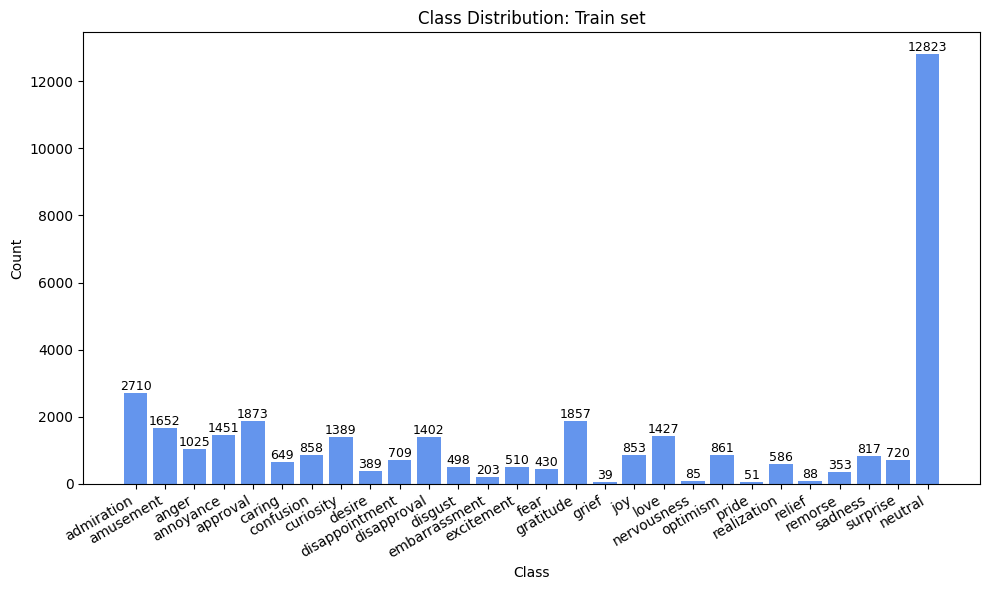

In [13]:
class_count = class_distribution_plot(TV_y_train, class_labels, 'Train set')

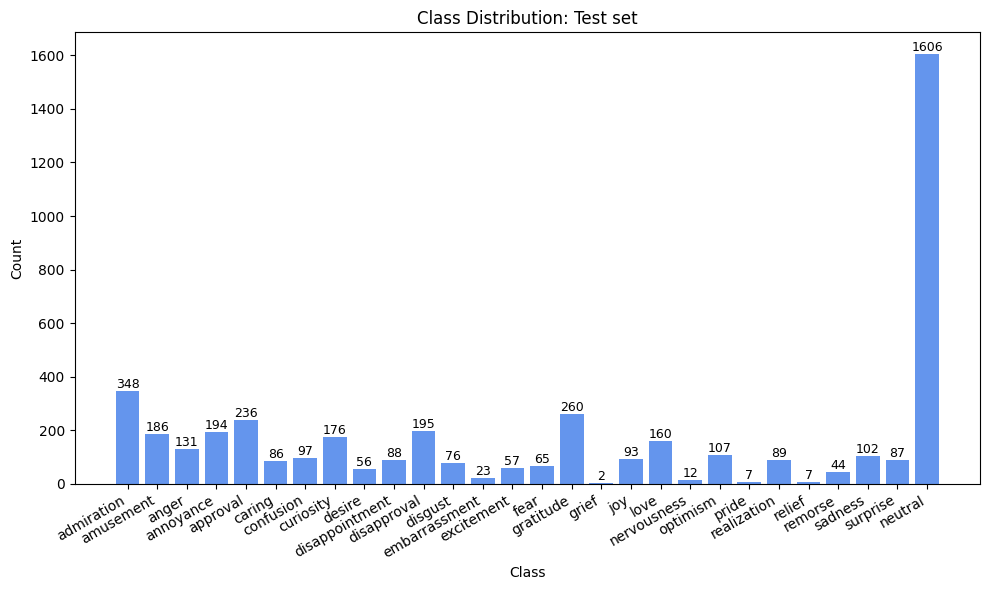

In [14]:
class_count_test = class_distribution_plot(TV_y_test, class_labels, 'Test set')

### *Random Forest*

* RF settings

    The n_estimators parameter determines the number of decision trees. Increasing it to 200 caused overfitting and higher computation time, while reducing it to 70 led to underfitting and poor performance. Using 120 trees strikes a balance between model complexity and computational efficiency. The max_leaf_nodes limits tree complexity, and setting it to 3500 aims to prevent overfitting by avoiding overly deep trees while preserving flexibility to capture features. The min_samples_split specifies the minimum samples required to split a node, and a value of 5 efficiently reduces noise in sparse data. After testing various configurations, the combination of n_estimators=120, max_leaf_nodes=3500, and min_samples_split=5 yielded the best performance

* Classification Performance

In [15]:
# TfidfVectorizer
TV_rf_model = RandomForestClassifier(n_estimators=120, max_leaf_nodes=3500, min_samples_split=5, random_state=42)
start_time = time.time()
TV_rf_model.fit(TV_x_train_vectorized, TV_y_train)
end_time = time.time()
TV_y_pred = TV_rf_model.predict(TV_x_test_vectorized)
TV_y_pred_train = TV_rf_model.predict(TV_x_train_vectorized)

# Evaluate the model
print("Train Accuracy:", accuracy_score(TV_y_train, TV_y_pred_train))
print("Test Accuracy:", accuracy_score(TV_y_test, TV_y_pred))
print("Classification Report:\n", classification_report(TV_y_test, TV_y_pred, zero_division=0.0))
print(f'Training Time: {end_time - start_time:.2f} seconds')


Train Accuracy: 0.7148011457530021
Test Accuracy: 0.5747276688453159
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.62      0.60       348
           1       0.74      0.81      0.77       186
           2       0.47      0.37      0.41       131
           3       0.49      0.09      0.16       194
           4       0.50      0.14      0.22       236
           5       0.64      0.19      0.29        86
           6       0.50      0.14      0.22        97
           7       0.57      0.07      0.12       176
           8       0.57      0.23      0.33        56
           9       0.67      0.07      0.12        88
          10       0.48      0.06      0.11       195
          11       0.62      0.39      0.48        76
          12       0.67      0.26      0.38        23
          13       0.70      0.37      0.48        57
          14       0.65      0.57      0.61        65
          15       0.93      0.89      0.9

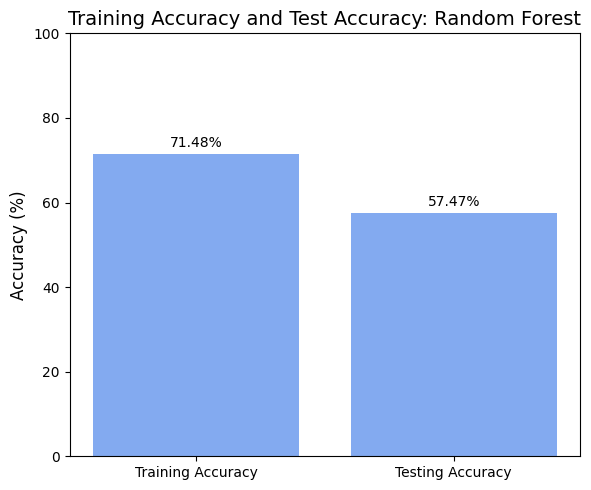

In [ ]:
plot_accuracies(accuracy_score(TV_y_train, TV_y_pred_train), accuracy_score(TV_y_test, TV_y_pred), 'Random Forest')

* Confusion Matrix

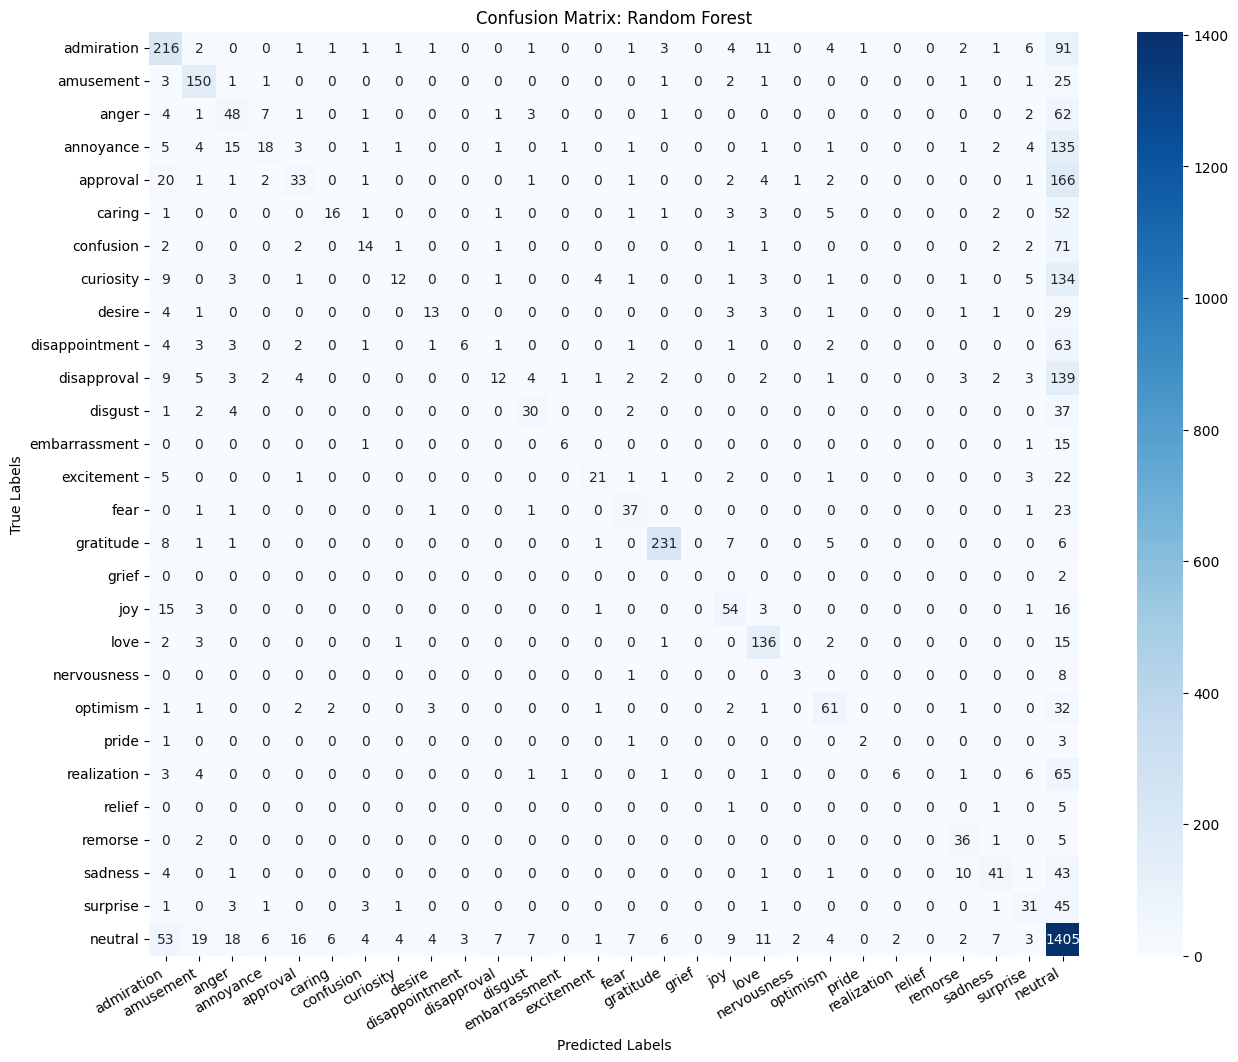

In [16]:
confusion_matrix_plot(TV_y_test, TV_y_pred, class_labels, 'Random Forest')

* RF classification report

   Despite efforts to control overfitting, the performance report indicates some degree of overfitting, as evidenced by the gap between training accuracy (71.48%) and test accuracy (57.47%). While the chosen settings help manage tree complexity and improve generalization compared to more extreme configurations, the model still struggles with class imbalance in the dataset. These settings provide higher test accuracy and partially reduce overfitting but cannot avoid it entirely.

    Class-level observations reveal that calss 1 ('amusement', 1652 smaples) with an f1-score of 0.77, class 15 ('gratitude', 1857 samples) with an f1-score of 0.91, and class 18 ('love', 1427 samples) with an f1-score of 0.79 are modeled relatively well. These classes are likely easier for the Random Forest to learn due to their distinct features or sufficient number of samples in the dataset. In contrast, classes such as 16 ('grief', 39 samples), and 23 ('relief', 88 samples) perform poorly, with precision, recall, and f1-scores close to zero. This poor performance is likely due to insufficient data or significant feature overlap with other classes. Class 27 ('neutral', 12823 samples) dominates model learning due to its much larger size relative to other classes, leading to relatively good performance (f1-score of 0.65 and recall of 0.87). Its high recall values indicates the model has a strong bias toward this class. The confusion matrix reveals that many classes are frequently misclassified as 'neutral', especially for classes such as 'approval' 'disapproval', 'annoyance', and 'curiosity'.

    The macro-average f1-score of 0.40 reveals poor overall class-level performance, while the weighted-average f1-score of 0.52 suggests that the model performs better on dominant classes but struggles significantly with minority classes. These metrics indicate that although the Random Forest model performs well on a few dominant or distinct classes, it fails to generalize effectively across the less frequent or more ambiguous classes.

### *Naive Bayes*

* NB implementation explanation

    To implement the Naive Bayes algorithm, a custom class (MultinomialNB) was developed. The decision to use Multinomial Naive Bayes stems from its ability to handle feature counts effectively, which makes it an ideal choice for text classification tasks. 
    
    Laplace smoothing is implemented to address zero probabilities, with two hyperparameters controlling its behavior: laplace_smoothing, a flag to enable or disable smoothing, and alpha, the smoothing constant, which can be manually set. The model’s parameters include priors: reflect the relative frequency of each class label in the dataset; likelihoods: store the conditional probabilities of each feature given a class; classes: contain the unique class labels present in the dataset.

    The fit function is used to train the model. It takes the feature matrix x and the corresponding class labels y as inputs. The function first computes the prior probabilities. It then filters the training samples belonging to each class and calculates the likelihoods for each feature, either with or without Laplace smoothing, depending on the chosen settings.

    The predict function takes the feature matrix x as input. It first converts the priors and likelihoods to logarithms to prevent numerical underflow during computation. Then, for each class, it calculates the log posterior probability. The function outputs the class with the highest log posterior for each sample.

    To evaluate the model performance, evaluate_acc function is defined. It takes predicted labels and true labels as inputs and computes the accuracy score as the proportion of correctly classified samples. 

In [18]:
class MultinomialNB:
    def __init__(self, laplace_smoothing=True, alpha=1):
        self.laplace_smoothing = laplace_smoothing
        self.alpha = alpha
        self.priors = None # prior class probability: frequency of observing this label
        self.likelihoods = None # conditional probabilities of each feature given a class
        self.classes = None # unique classes in the dataset
    
    def fit(self, x, y):
        self.classes, class_counts = np.unique(y, return_counts=True)
        num_classes = len(self.classes)
        num_features = x.shape[1]
        
        self.priors = class_counts / len(y) # compute class priors
        self.likelihoods = np.zeros((num_classes, num_features))

        for idx, cls in enumerate(self.classes):
            x_cls = x[y == cls]
            if self.laplace_smoothing:
                self.likelihoods[idx, :] = (np.sum(x_cls, axis=0) + self.alpha) / (np.sum(x_cls) + self.alpha * num_features)
            else:
                self.likelihoods[idx, :] = (np.sum(x_cls, axis=0)) / (np.sum(x_cls))
    
    def predict(self, x):
        log_priors = np.log(self.priors)
        log_likelihoods = np.log(self.likelihoods + 1e-9) # avoid taking log(0)
        log_posteriors = x @ log_likelihoods.T + log_priors
        return np.argmax(log_posteriors, axis=1)

    def evaluate_acc(self, y_pred, y_true):
        return np.mean(y_true == y_pred)

In [17]:
# CountVectorizer
x_train_nb, y_train_nb = df['text'], df['label']
x_test_nb, y_test_nb = df_test['text'], df_test['label']
vectorizer_nb = CountVectorizer(ngram_range=(1, 3), max_features=1000)
x_train_vectorized_nb = vectorizer_nb.fit_transform(x_train_nb).toarray()
x_test_vectorized_nb = vectorizer_nb.transform(x_test_nb).toarray()

* Classification Performance

In [24]:
naive_bayes_model = MultinomialNB(laplace_smoothing=True, alpha=4) #0.75
start_time_nb = time.time()
naive_bayes_model.fit(x_train_vectorized_nb, y_train_nb)
end_time_nb = time.time()
y_train_pred_nb = naive_bayes_model.predict(x_train_vectorized_nb)
y_pred_nb = naive_bayes_model.predict(x_test_vectorized_nb)
print("Train Accuracy:", naive_bayes_model.evaluate_acc(y_train_pred_nb, y_train_nb))
print("Test Accuracy:", naive_bayes_model.evaluate_acc(y_pred_nb, y_test_nb))
print("Classification Report:\n", classification_report(y_test_nb, y_pred_nb, zero_division=0.0))
print(f'Training Time: {end_time_nb - start_time_nb:.2f} seconds')

Train Accuracy: 0.5535143769968051
Test Accuracy: 0.5261437908496732
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.50      0.53       348
           1       0.76      0.61      0.67       186
           2       0.48      0.17      0.25       131
           3       0.42      0.07      0.12       194
           4       0.52      0.14      0.23       236
           5       0.58      0.08      0.14        86
           6       0.39      0.20      0.26        97
           7       0.42      0.05      0.08       176
           8       0.43      0.05      0.10        56
           9       0.50      0.03      0.06        88
          10       0.39      0.09      0.15       195
          11       0.74      0.22      0.34        76
          12       0.00      0.00      0.00        23
          13       0.53      0.16      0.24        57
          14       0.91      0.15      0.26        65
          15       0.88      0.86      0.8

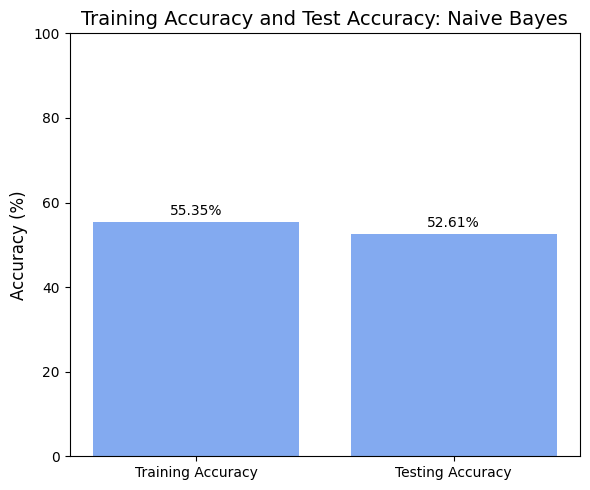

In [ ]:
plot_accuracies(naive_bayes_model.evaluate_acc(y_train_pred_nb, y_train_nb), naive_bayes_model.evaluate_acc(y_pred_nb, y_test_nb), 'Naive Bayes')

* Confusion Matrix

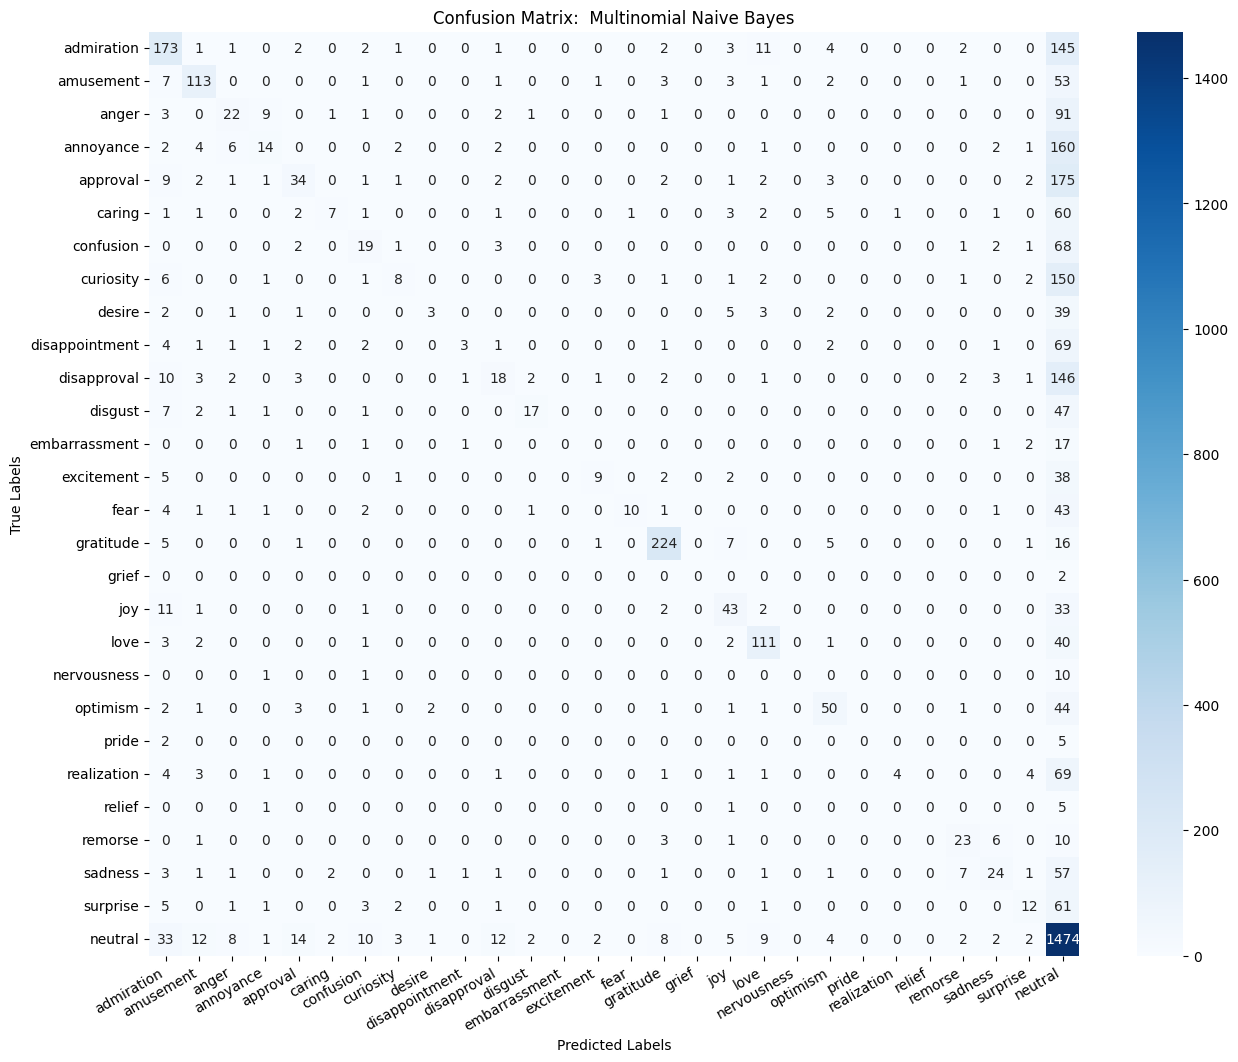

In [25]:
confusion_matrix_plot(y_test_nb, y_pred_nb, class_labels, ' Multinomial Naive Bayes')

* NB classification report

    The model achieves a training accuracy of 55.35% and a test accuracy of 52.61%. This low accuracy is reasonable，as the assumption of feature independence limits its ability to capture relationships between words, which are often essential in identifying subtle differences between emotions. The use of Laplace smoothing (alpha = 4) helps prevent zero probabilities for unseen features but may still struggle with extremely underrepresented classes.

    Class 15 ('gratitude', 1857 samples, f1-score: 0.87) and class 18 ('love', 1427 samples, f1-score: 0.72) perform relatively well. These classes contain sufficient smaples and may have more distinct feature distributions, making it easier for the model to identify them. On the other hand, several classes, such as 12('embarassment', 203 samples), 16 ('grief', 39 samples), 19('nervousness', 85 samples), 21 ('pride', 51 samples), and 23 ('relief', 88 samples), have precision, recall, and f1-scores equal to zero. This is likely due to a combination of insufficient samples in the training data and overlapping features with other classes, which challenges the Naive Bayes assumption of feature independence. Class 27 ('neutral', 12823 samples) dominates the model with an f1-score of 0.62 and recall of 0.92. This is expected given the class imbalance in the dataset, where class 'neutral' has significantly more samples. The model tends to favor this class, resulting in very few false negative for 'neutral' due to its larger frequency. The confusion matrix reveals a tendency to misclassify other emotional categories as the dominant class 'neutral'.

    The macro-average f1-score of 0.28 reflects poor performance across all classes, particularly the minority ones, as the metric gives equal weight to all classes regardless of size. The weighted-average f1-score of 0.46 is slightly better because it accounts for class imbalance, giving more weight to the dominant class 'neutral.'

NB performance without Laplace Smoothing

In [26]:
naive_bayes_model_no_ls = MultinomialNB(laplace_smoothing=False) #0.75
start_time_nb = time.time()
naive_bayes_model_no_ls.fit(x_train_vectorized_nb, y_train_nb)
end_time_nb = time.time()
y_train_pred_nb = naive_bayes_model_no_ls.predict(x_train_vectorized_nb)
y_pred_nb_no_ls = naive_bayes_model_no_ls.predict(x_test_vectorized_nb)
print("Train Accuracy:", naive_bayes_model_no_ls.evaluate_acc(y_train_pred_nb, y_train_nb))
print("Test Accuracy:", naive_bayes_model_no_ls.evaluate_acc(y_pred_nb_no_ls, y_test_nb))
print("Classification Report:\n", classification_report(y_test_nb, y_pred_nb_no_ls, zero_division=0.0))
print(f'Training Time: {end_time_nb - start_time_nb:.2f} seconds')

Train Accuracy: 0.5895670375674782
Test Accuracy: 0.5122004357298475
Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.47      0.51       348
           1       0.73      0.59      0.65       186
           2       0.50      0.26      0.34       131
           3       0.35      0.13      0.19       194
           4       0.45      0.18      0.26       236
           5       0.31      0.21      0.25        86
           6       0.29      0.19      0.23        97
           7       0.28      0.07      0.12       176
           8       0.36      0.16      0.22        56
           9       0.25      0.10      0.15        88
          10       0.23      0.13      0.17       195
          11       0.49      0.30      0.37        76
          12       0.17      0.09      0.11        23
          13       0.28      0.23      0.25        57
          14       0.57      0.31      0.40        65
          15       0.82      0.81      0.8

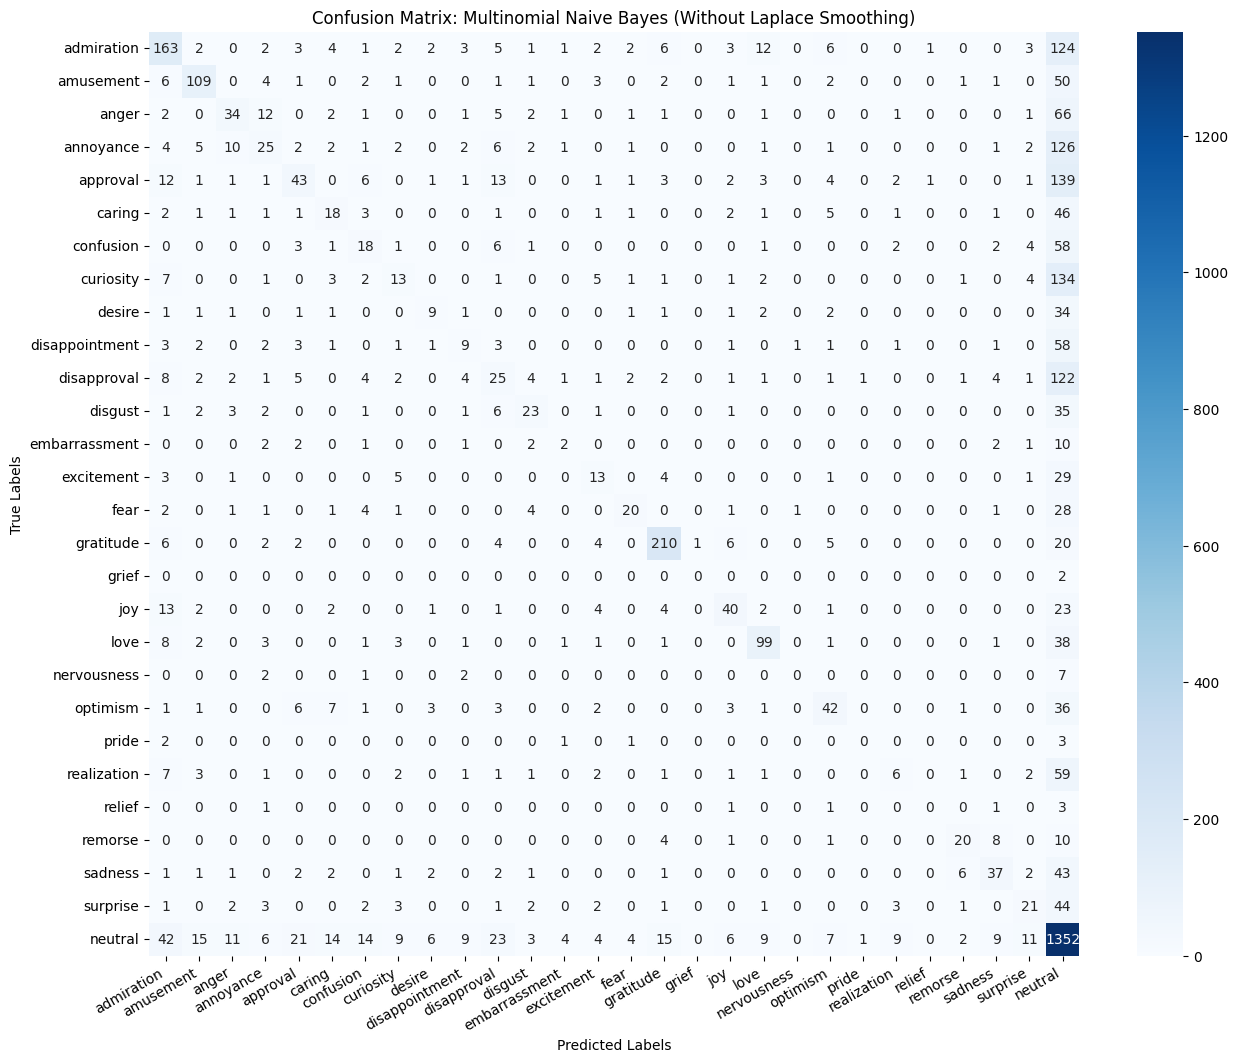

In [27]:
confusion_matrix_plot(y_test_nb, y_pred_nb_no_ls, class_labels, 'Multinomial Naive Bayes (Without Laplace Smoothing)')

* NB performance without Laplace

    Compared with the performance of the Multinomial Naive Bayes model with Lapalce smoothing, the performance of the one without Laplace smoothing shows a slight improvement in training accuracy (58.96%), but the test accuracy (51.22%) slightly decreases, indicating that it fits the training data better yet still struggles to generalize well to unseen data. This may be because, without smoothing, the model assigns higher probabilities to seen features, which might lead to a better fit on the training set but at the cost of generalization Their class-level performances, macro-average, and weighted-average of three metrics are similar.

* NB performance without removing stopwords

In [ ]:
x_orig_train_nb, y_orig_train_nb = df_original['text'], df_original['label']
x_orig_test_nb, y_orig_test_nb = df_test_original['text'], df_test_original['label']
x_orig_train_vectorized_nb = vectorizer_nb.fit_transform(x_orig_train_nb).toarray()
x_orig_test_vectorized_nb = vectorizer_nb.fit_transform(x_orig_test_nb).toarray()

In [30]:
naive_bayes_model_no_stpw = MultinomialNB(laplace_smoothing=True, alpha=3.99) #0.75

start_time_nb = time.time()
naive_bayes_model_no_stpw.fit(x_orig_train_vectorized_nb, y_orig_train_nb)
end_time_nb = time.time()
y_train_orig_pred_nb = naive_bayes_model_no_stpw.predict(x_orig_train_vectorized_nb)
y_test_orig_pred_nb = naive_bayes_model_no_stpw.predict(x_orig_test_vectorized_nb)
print("Train Accuracy:", naive_bayes_model_no_stpw.evaluate_acc(y_train_orig_pred_nb, y_orig_train_nb))
print("Test Accuracy:", naive_bayes_model_no_stpw.evaluate_acc(y_test_orig_pred_nb, y_orig_test_nb))
print("Classification Report:\n", classification_report(y_orig_test_nb, y_test_orig_pred_nb, zero_division=0.0))
print(f'Training Time: {end_time_nb - start_time_nb:.2f} seconds')

Train Accuracy: 0.5370441775917153
Test Accuracy: 0.19564270152505447
Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.06      0.08       348
           1       0.03      0.02      0.02       186
           2       0.02      0.02      0.02       131
           3       0.11      0.01      0.02       194
           4       0.31      0.08      0.13       236
           5       0.01      0.01      0.01        86
           6       0.02      0.02      0.02        97
           7       0.06      0.02      0.03       176
           8       0.00      0.00      0.00        56
           9       0.00      0.00      0.00        88
          10       0.09      0.03      0.04       195
          11       0.01      0.01      0.01        76
          12       0.01      0.04      0.01        23
          13       0.04      0.05      0.05        57
          14       0.00      0.00      0.00        65
          15       0.06      0.04      0.

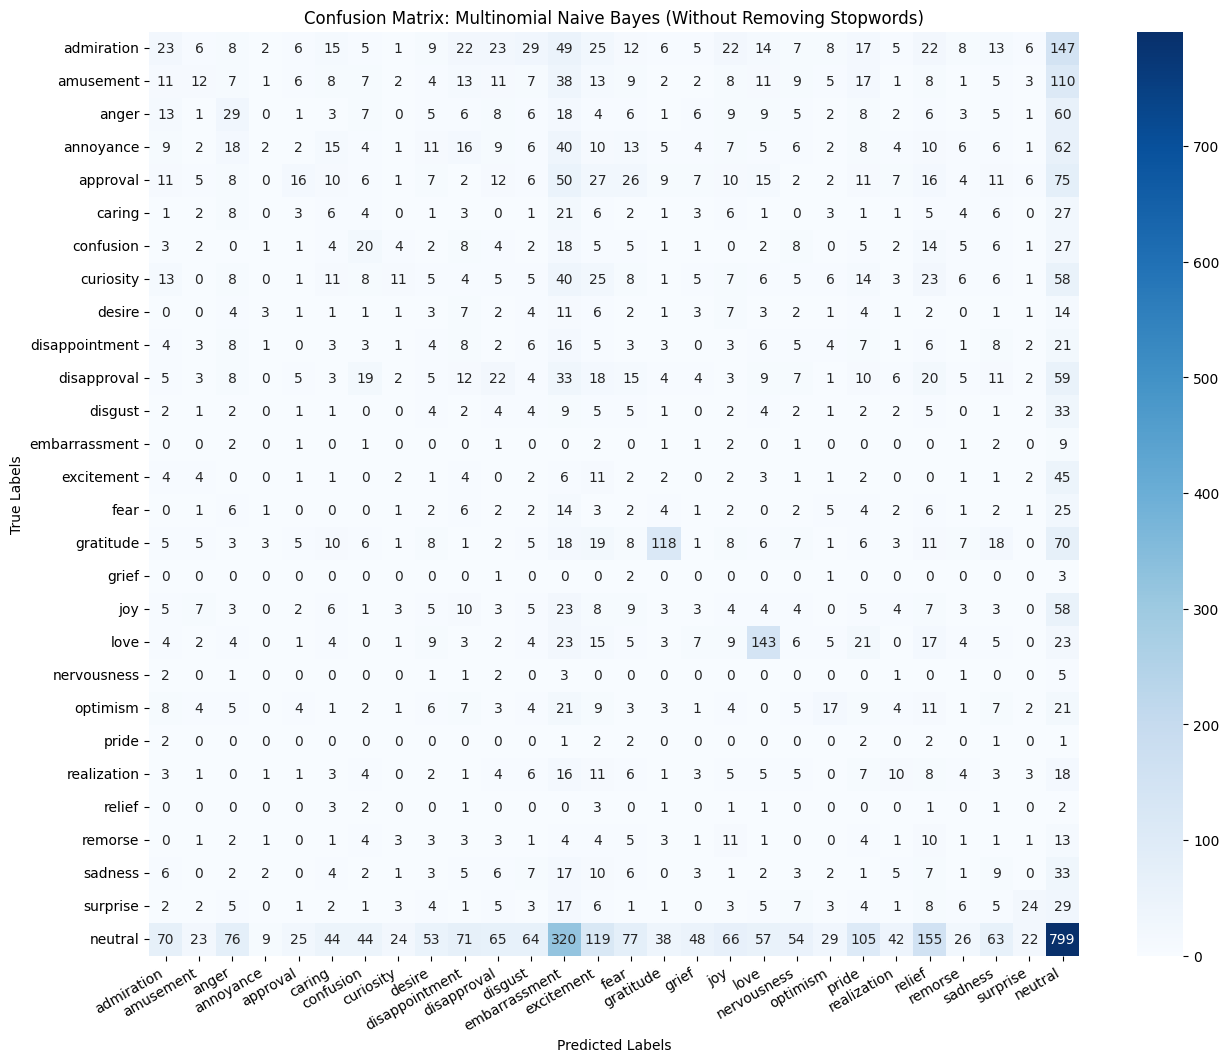

In [ ]:
confusion_matrix_plot(y_orig_test_nb, y_test_orig_pred_nb, class_labels, 'Multinomial Naive Bayes (Without Removing Stopwords)')

Without removing stopwords, the model achieved a training accuracy of 53.70% and a test accuracy of 19.56%. This performance was significantly worse compared to models trained on data with stopwords removed. Class-level performances, as well as the macro-average and weighted-averages of all three metrics, also decreased substantially. These results demonstrate that removing stopwords from the training set significantly improves the model's performance.


* NB performance with SMOTE

In [65]:
target_size = 4200
samples_to_add = {}
for cls, count in class_count.items():
    if count < target_size:
        samples_to_add[cls] = max(0, target_size - count)

x_train_smote, y_train_smote = x_train_vectorized_nb, y_train_nb
for cls, num_samples in samples_to_add.items():
    if num_samples > 0:
        x_train_smote, y_train_smote = smote(x_train_smote, y_train_smote, target_class=cls, num_samples=num_samples)

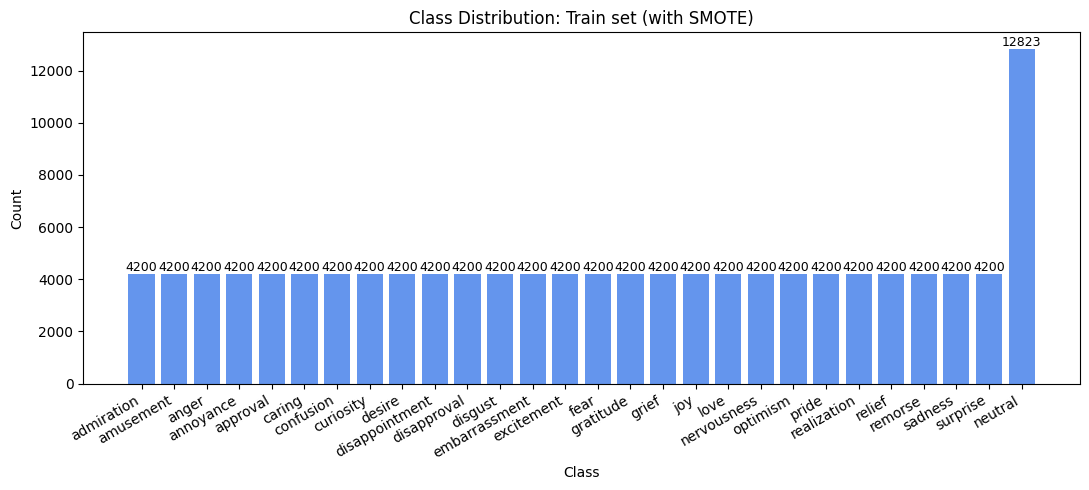

In [68]:
class_count_smote = class_distribution_plot(y_train_smote, class_labels, 'Train set (with SMOTE)', size=(11, 5))

In [69]:
naive_bayes_model_smote = MultinomialNB(laplace_smoothing=True, alpha=4)

start_time_nb = time.time()
naive_bayes_model_smote.fit(x_train_smote, y_train_smote)
end_time_nb = time.time()
y_train_pred_smote_nb = naive_bayes_model_smote.predict(x_train_smote)
y_test_pred_smote_nb = naive_bayes_model_smote.predict(x_test_vectorized_nb)
print("Train Accuracy:", naive_bayes_model_smote.evaluate_acc(y_train_pred_smote_nb, y_train_smote))
print("Test Accuracy:", naive_bayes_model_smote.evaluate_acc(y_test_pred_smote_nb, y_test_nb))
print("Classification Report:\n", classification_report(y_test_nb, y_test_pred_smote_nb, zero_division=0.0))
print(f'Training Time: {end_time_nb - start_time_nb:.2f} seconds')

Train Accuracy: 0.5316780618429288
Test Accuracy: 0.43638344226579523
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.39      0.46       348
           1       0.74      0.65      0.69       186
           2       0.44      0.37      0.40       131
           3       0.25      0.09      0.13       194
           4       0.40      0.20      0.27       236
           5       0.15      0.24      0.19        86
           6       0.20      0.28      0.23        97
           7       0.24      0.11      0.16       176
           8       0.31      0.43      0.36        56
           9       0.13      0.15      0.14        88
          10       0.25      0.19      0.22       195
          11       0.41      0.46      0.43        76
          12       0.05      0.17      0.07        23
          13       0.19      0.35      0.25        57
          14       0.35      0.51      0.41        65
          15       0.86      0.85      0.

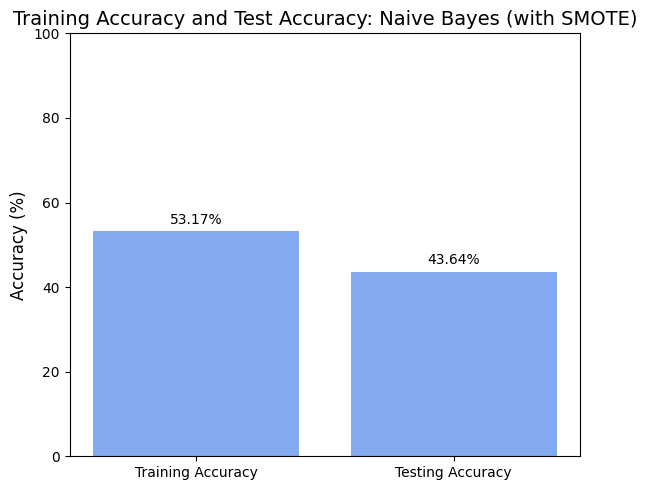

In [ ]:
plot_accuracies(naive_bayes_model_smote.evaluate_acc(y_train_pred_smote_nb, y_train_smote), naive_bayes_model_smote.evaluate_acc(y_test_pred_smote_nb, y_test_nb), 'Naive Bayes (with SMOTE)')

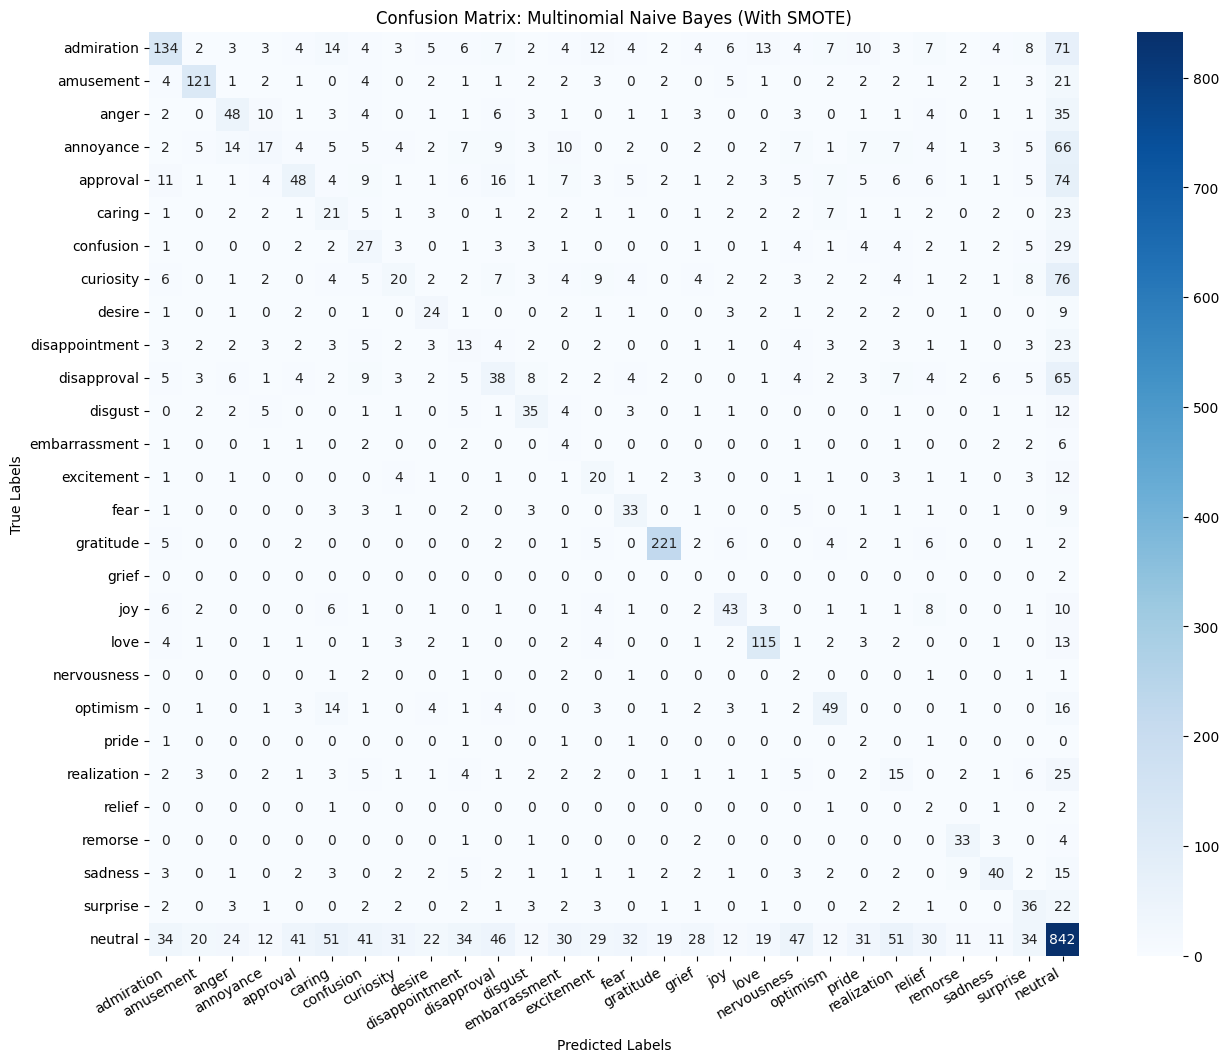

In [ ]:
confusion_matrix_plot(y_test_nb, y_test_pred_smote_nb, class_labels, 'Multinomial Naive Bayes (With SMOTE)')

* NB performance with SMOTE

    To deal with class imbalance issue, SMOTE is applied to all the other classes other than class 27 ('neutral'). Class 'neutral' still has 12823 samples, while the other classes now each has 4200 samples, which is almost one-third of samples in 'netural'. 

    With all the other parameters the same (laplace_smooth = True and alpha = 4), compared to the model trained without SMOTE, the one with SMOTE has a lower training accuracy (from 55.32% to 53.16%) and a lower test accuracy (from 52.61% to 43.63%). The decreased training and test accuracy indicates that the inclusion of sythetic samples introduces noise or unrealistic feature combinations that makes it harder for the model to learn clear decision boundaries and does not generate well to the unseen data.

    SMOTE boosts recall and slightly increases precision and f1-score of minority classes such as class 12 'embarassment', class 21 'pride', and class 23 'relief', which previously have zero performance. These improvements demostrate the sythetic data in enabling the model to assign probabilities to minority classes. However, performance on class 'neutral' suffers. Its f1-score dropped from 0.62 to 0.54, which contributes a lot to the overall decline in test accuracy. The confusion matrix also shows the minority calsses are less likely to be misclassified as class 'neutral'. This is likely because the model gives more weight to the minority classes at the cost of reduing its focus on majority class predictions.

    The macro-average of precison, recall, and f1-score of model with SMOTE increased, which indicates that the minority classes benefit from the oversampling strategy, improving their overall performance. However, the weighted-average of all three metrics drops, as the model focuses less on the dominant class. 

* NB performance with under sampling the majority classes

In [93]:
target_class = 27
num_samples = 3500
y_train_nb = np.array(y_train_nb)
x_train_under_sample, y_train_under_sample = undersample(x_train_vectorized_nb, y_train_nb, target_class, num_samples)

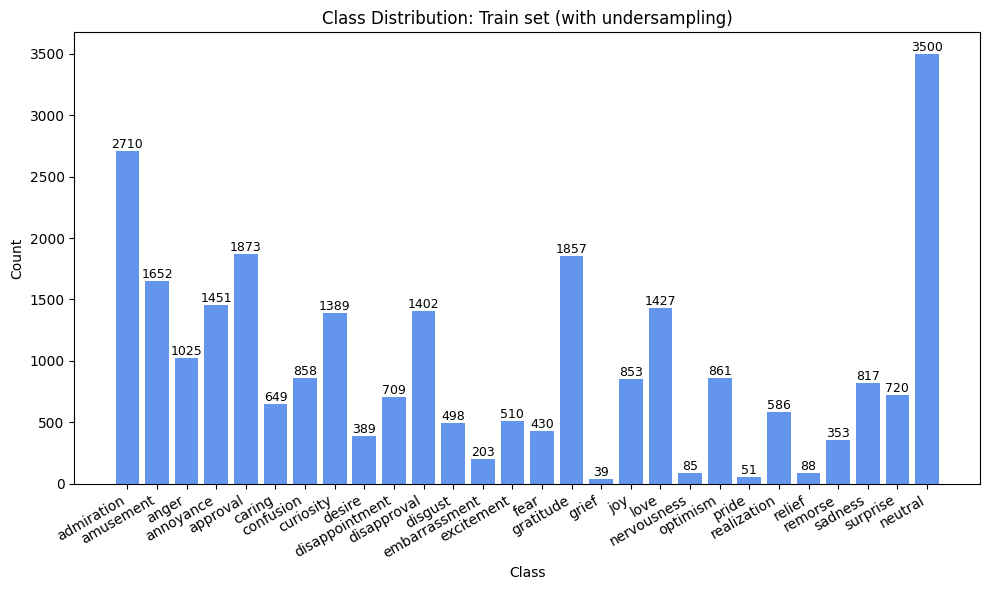

In [94]:
class_count_under_sample = class_distribution_plot(y_train_under_sample, class_labels, 'Train set (with undersampling)')

In [95]:
naive_bayes_model_under_sample = MultinomialNB(laplace_smoothing=True, alpha=4)

start_time_nb = time.time()
naive_bayes_model_under_sample.fit(x_train_under_sample, y_train_under_sample)
end_time_nb = time.time()
y_train_pred_under_nb = naive_bayes_model_under_sample.predict(x_train_under_sample)
y_test_pred_under_nb = naive_bayes_model_under_sample.predict(x_test_vectorized_nb)
print("Train Accuracy:", naive_bayes_model_under_sample.evaluate_acc(y_train_pred_under_nb, y_train_under_sample))
print("Test Accuracy:", naive_bayes_model_under_sample.evaluate_acc(y_test_pred_under_nb, y_test_nb))
print("Classification Report:\n", classification_report(y_test_nb, y_test_pred_under_nb, zero_division=0.0))
print(f'Training Time: {end_time_nb - start_time_nb:.2f} seconds')

Train Accuracy: 0.4907911802853437
Test Accuracy: 0.48997821350762527
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.66      0.46       348
           1       0.68      0.73      0.70       186
           2       0.52      0.35      0.42       131
           3       0.29      0.16      0.21       194
           4       0.27      0.31      0.29       236
           5       0.38      0.17      0.24        86
           6       0.26      0.24      0.25        97
           7       0.23      0.12      0.16       176
           8       0.54      0.12      0.20        56
           9       0.25      0.06      0.09        88
          10       0.23      0.21      0.22       195
          11       0.68      0.28      0.39        76
          12       1.00      0.04      0.08        23
          13       0.50      0.21      0.30        57
          14       0.89      0.26      0.40        65
          15       0.69      0.89      0.

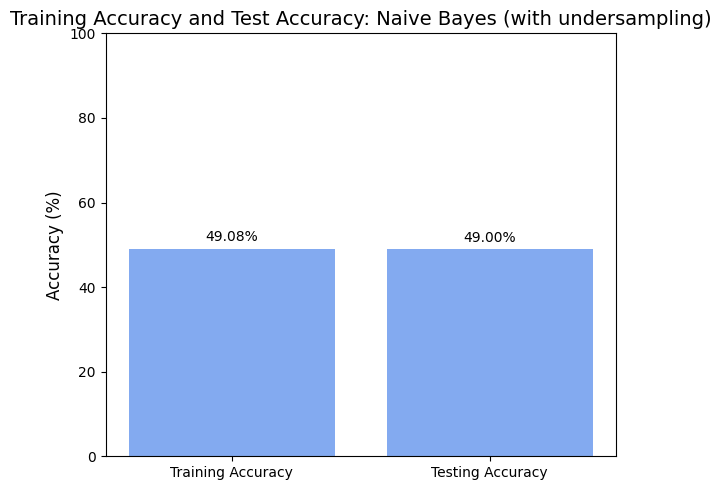

In [ ]:
plot_accuracies(naive_bayes_model_under_sample.evaluate_acc(y_train_pred_under_nb, y_train_under_sample), naive_bayes_model_under_sample.evaluate_acc(y_test_pred_under_nb, y_test_nb), 'Naive Bayes (with undersampling)')

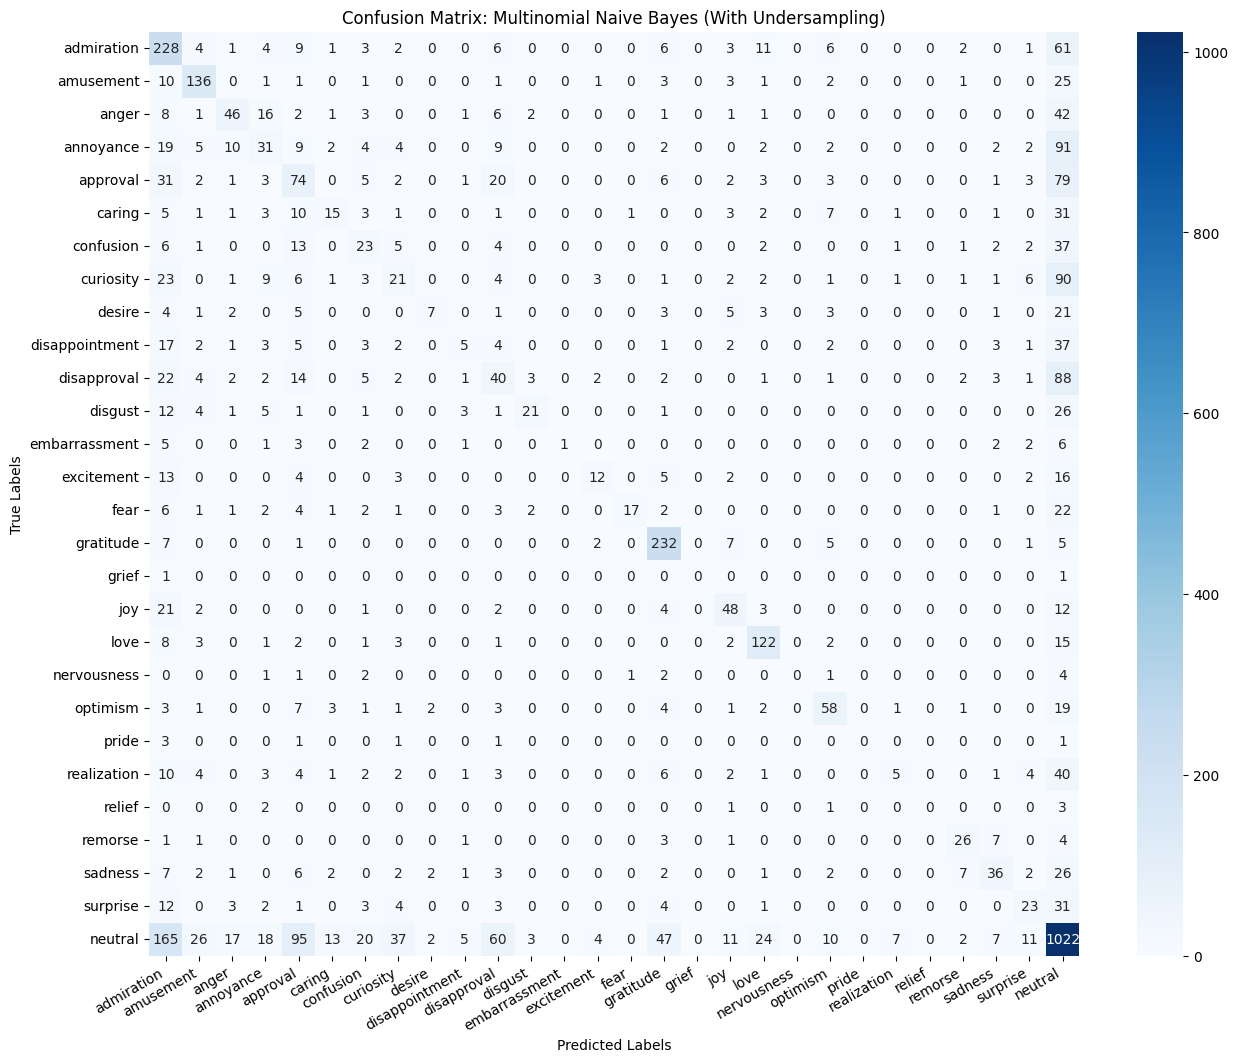

In [96]:
confusion_matrix_plot(y_test_nb, y_test_pred_under_nb, class_labels, 'Multinomial Naive Bayes (With Undersampling)')

* NB performance with ubdersampling the majority class

    This time undersampling is applied to class 27 ('neutral') to address the class imbalance issue. With all the other factors unchanged, class 'neutral' is being down sampled to 3500 samples. Class 27 now includes three times the average of the size of other minority classes. This size achieves a practical balance between retaining sufficient data for Class 'neutral' while allowing minority classes to be more focused.

    Undersampling leads to decreasing training accuracy (from 55.35% to 49.08%) and test accuracy (from 52.61% to 49.00%). The reduced representation of the dominant class limits its influence on the model, but it helps the model be less biased towards the class 27.

    Since model is less favoring class 27, there are fewer false positives for it and its precison increases. However, its recall and f1-score decreased as a term of balanced trade-off. Minority classes' metrics are still low. Class 12 ('embarassment') reaches a precision of 1, and yet its recall and f1-score are still poor. This is becasuse of its small size, and even though there's no falspositive for it, there are still a lot of false negatives. 
    
    The undersampled model shows a better macro-average f1-score (from 0.28 to 0.32), meaning the model achieves improved performance on minority classes by reducing the over-representation of class 27. The weighted average F1-scores of both models are similar, and are both much closer to the majority class performance. This is because class 27 is still the majority class even after downsampling.

    These evidence shows that undersampling cannot address the class imbalance issue effectively. 

* NB performance with both SMOTE and under sampling the majority classes

In [101]:
target_size = 4000
samples_to_add2 = {}
for cls, count in class_count.items():
    if count < target_size:
        samples_to_add2[cls] = max(0, target_size - count)

x_train_smote2, y_train_smote2 = x_train_vectorized_nb, y_train_nb
for cls, num_samples in samples_to_add2.items():
    if num_samples > 0:
        x_train_smote2, y_train_smote2 = smote(x_train_smote2, y_train_smote2, target_class=cls, num_samples=num_samples)

In [102]:
target_class = 27
num_samples = 4000
x_train_both, y_train_both = undersample(x_train_smote2, y_train_smote2, target_class, num_samples)

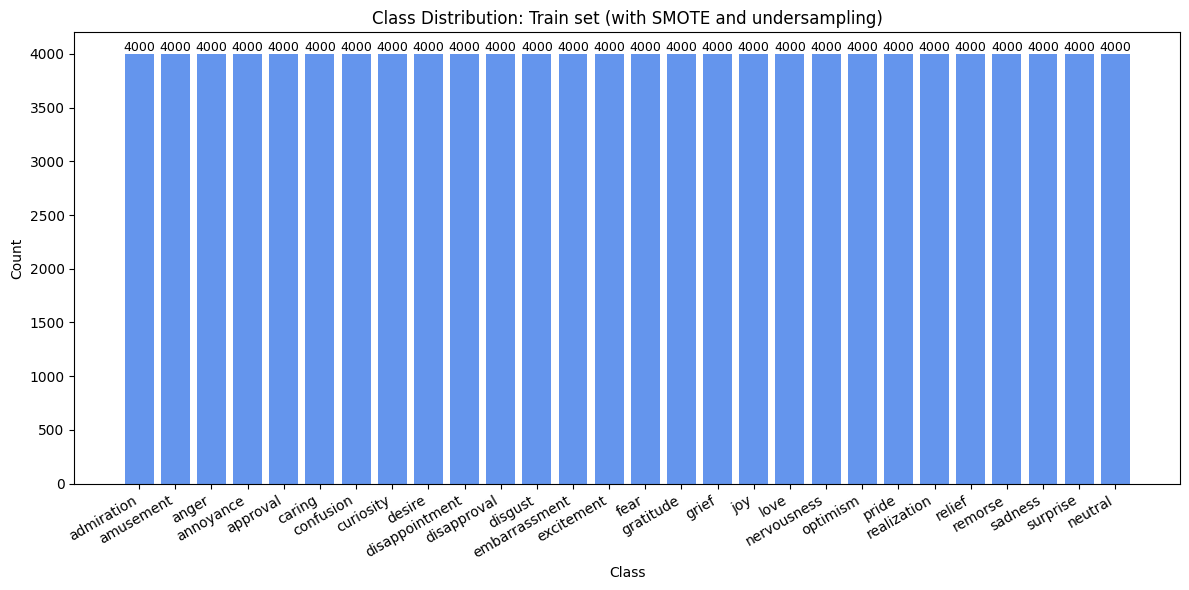

In [103]:
class_count_under_sample = class_distribution_plot(y_train_both, class_labels, 'Train set (with SMOTE and undersampling)', size=(12, 6))

In [104]:
naive_bayes_model_both = MultinomialNB(laplace_smoothing=True, alpha=3.99)

start_time_nb = time.time()
naive_bayes_model_both.fit(x_train_both, y_train_both)
end_time_nb = time.time()
y_train_pred_both_nb = naive_bayes_model_both.predict(x_train_both)
y_test_pred_both_nb = naive_bayes_model_both.predict(x_test_vectorized_nb)
print("Train Accuracy:", naive_bayes_model_both.evaluate_acc(y_train_pred_both_nb, y_train_both))
print("Test Accuracy:", naive_bayes_model_both.evaluate_acc(y_test_pred_both_nb, y_test_nb))
print("Classification Report:\n", classification_report(y_test_nb, y_test_pred_both_nb, zero_division=0.0))
print(f'Training Time: {end_time_nb - start_time_nb:.2f} seconds')

Train Accuracy: 0.5863392857142857
Test Accuracy: 0.2945533769063181
Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.46      0.40       348
           1       0.69      0.69      0.69       186
           2       0.38      0.40      0.39       131
           3       0.20      0.13      0.16       194
           4       0.29      0.22      0.25       236
           5       0.13      0.31      0.18        86
           6       0.15      0.30      0.20        97
           7       0.18      0.16      0.17       176
           8       0.20      0.45      0.28        56
           9       0.09      0.18      0.12        88
          10       0.19      0.24      0.21       195
          11       0.30      0.46      0.36        76
          12       0.03      0.17      0.05        23
          13       0.15      0.37      0.21        57
          14       0.31      0.54      0.40        65
          15       0.84      0.85      0.8

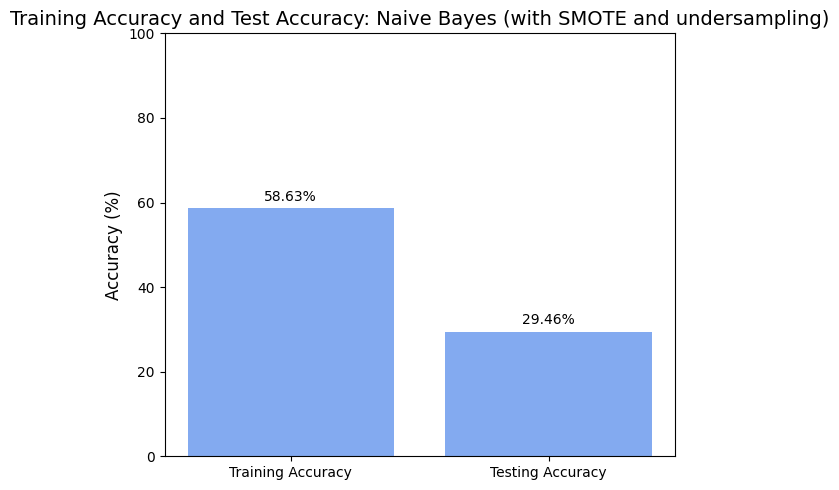

In [ ]:
plot_accuracies(naive_bayes_model_both.evaluate_acc(y_train_pred_both_nb, y_train_both), naive_bayes_model_both.evaluate_acc(y_test_pred_both_nb, y_test_nb), 'Naive Bayes (with SMOTE and undersampling)')

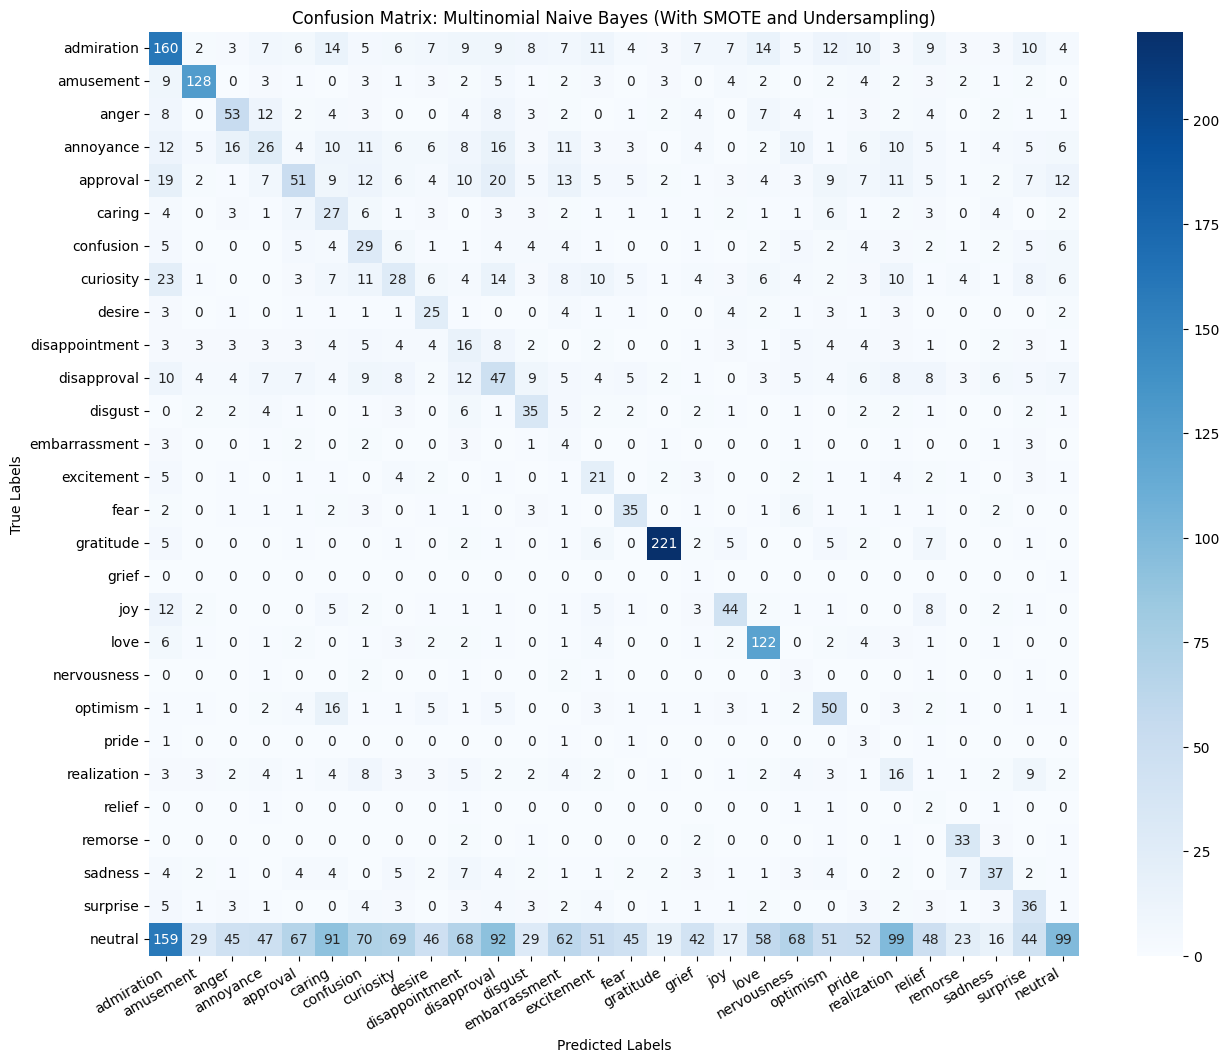

In [105]:
confusion_matrix_plot(y_test_nb, y_test_pred_both_nb, class_labels, 'Multinomial Naive Bayes (With SMOTE and Undersampling)')

* Model with both SMOTE and undersampling

    With all the other factors remain the same, SMOTE and majority class undersampling are both applied. This model achieves a higher training accuracy (from 55.35% to 58.63%) but a much lower test accuracy (from 52.61% to 29.46%). This is because teh model can learn better on the balanced training dataset. However, the model no longer relies on the majority class for strong predictions. It redistributes focus across all classes, which results in reduced test accuracy.

    This model performs better on minority classes such as class 12 ('embarrassment'), class 16 ('grief'), class 21 ('pride'), and class 23 ('relief'), which has three metrics eqaul to zero. Their recall value significantly increases, and their precision and f1-score slightly increase as well. However, the majority class, class 27 ('neutral'), has much lower metrics. This may be due to the reduced focus on the dominant class.

    The macro average f1-score has no change, and yet the macro-average recall increased. This shows the model captures more instances from both minority and the majority classes. The weighted average f1-score decreases, whcih also reflects poorer performance on the dominant class 27 but improved handling of minority classes.

    Applying both the undersampling and SMOTE improves performance for minority classes, but sacrifices test accuracy and the performance of class 27. Hence, it is not the best way to deal with the class imbalance issue.